In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import ta as ta
from ta import add_all_ta_features
from ta.utils import dropna
from datetime import datetime

from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import *

from sklearn.preprocessing import MinMaxScaler


def preparar_dados_para_treinamento(anteriores,base_treinamento_normalizada):

    previsores = []
    preco_real = []

    for i in range(anteriores,len(base_treinamento_normalizada)):

        previsores.append(base_treinamento_normalizada[i-anteriores:i,0])
        preco_real.append(base_treinamento_normalizada[i,0])

    previsores,preco_real = np.array(previsores),np.array(preco_real)
    previsores = previsores
    
    return previsores,preco_real

def GetTsi(base,gaussian_knots,gaussian_sigma,ewm_span=20):
    
    tsi_config=[25,13]

    resultados_tsi = ta.momentum.TSIIndicator(base["Close"],tsi_config[0],tsi_config[1],False)

    tsi_df = pd.DataFrame(resultados_tsi.tsi())
    
    tsi_df.dropna(inplace=True)
    
    #Suavizando TSI com médias móveis exponenciais
    tsi_df["ewm"] = tsi_df['tsi'].ewm(span = ewm_span).mean()*1.2
    #------------------------------------------
    
    #Suavizanto TSI com gaussian smoother
    tsi_np = tsi_df["tsi"].to_numpy()
    tsi_np.reshape(1,len(tsi_np))

    smoother = GaussianSmoother(n_knots=gaussian_knots, sigma=gaussian_sigma)
    smoother.smooth(tsi_np)

    tsi_df["gaussian"] = smoother.smooth_data[0]
    #------------------------------------------
    
    return tsi_df

def GetRoc(base,gaussian_knots,gaussian_sigma,ewm_span=20):
    
    roc_config=[12]

    resultados_roc = ta.momentum.ROCIndicator(base["Close"],roc_config[0],False)
    
    roc_df = pd.DataFrame(resultados_roc.roc(),columns=["roc"])
    
    roc_df.dropna(inplace=True)
    
    #Suavizando ROC com médias móveis exponenciais
    roc_df["ewm"] = roc_df['roc'].ewm(span = ewm_span).mean()*1.2
    
    #Suavizanto ROC com gaussian smoother
    roc_np = roc_df["roc"].to_numpy()
    roc_np.reshape(1,len(roc_np))

    smoother = GaussianSmoother(n_knots=gaussian_knots, sigma=gaussian_sigma)
    smoother.smooth(roc_np)

    roc_df["gaussian"] = smoother.smooth_data[0]
    #------------------------------------------
    
    return roc_df

def Normalizar(Oscilador,coluna):
    
    normalizador = MinMaxScaler(feature_range=(0,1))
    
    if coluna == "tsi":
        Oscilador_treinamento = Oscilador.iloc[:,0:1].values
        
    if coluna == "ewm":
        Oscilador_treinamento = Oscilador.iloc[:,1:2].values
        
    if coluna == "gaussian":
        Oscilador_treinamento = Oscilador.iloc[:,2:3].values
        
    Oscilador_normalizado = normalizador.fit_transform(Oscilador_treinamento)
    
    return Oscilador_normalizado


def Criar_modelo_XGBoost(base,anteriores_,filepath,knots_=60,sigma_=0.0003,n_estimators_=300):

    #TSI
    tsi = GetTsi(base,knots,sigma)
    #--------------------------------

    #Normalizações
    normalizado = Normalizar(tsi,"gaussian")
    #--------------------------------

    X_train, y_train = preparar_dados_para_treinamento(anteriores,normalizado)


    reg = xgb.XGBRegressor(n_estimators=300)

    reg.fit(X_train, y_train,verbose=False)
    
    reg.save_model(filepath)
    
    print("Modelo pronto ",filepath)
    
    return reg


def Realizar_previsoes_XGBoost(qtd_previsoes,base,anteriores,modelo,knots=60,sigma=0.0003):


    ultimos_valores = base.tail(anteriores+37)

    tsi_atual = GetTsi(ultimos_valores,knots,sigma)

    normalizado = Normalizar(tsi_atual,"gaussian")

    x_reshape =normalizado.reshape(1,-1)

    lista_previsoes = list()

    
    i = 0

    while i < qtd_previsoes:

        previsao = modelo.predict(x_reshape)

        lista_previsoes.append(previsao)

        x_reshape =  np.append(x_reshape,previsao)

        x_reshape = np.delete(x_reshape,0)

        x_reshape =x_reshape.reshape(1,-1)

        i+=1
        
    return lista_previsoes


def Carregar_modelo_XGBoost(filepath):
    
    modelo_XGBoost = xgb.Booster()
    modelo_XGBoost.load_model(filepath)
    
    return modelo_XGBoost
    


In [8]:
#TSI

tsi_config=[25,13]
resultados_tsi = ta.momentum.TSIIndicator(df["Close"],tsi_config[0],tsi_config[1],False)

resultados_tsi.tsi().dropna(inplace=True)


#Gaussian TSI
resultados_tsi_sem_null = resultados_tsi.tsi().dropna()

tsi_np = resultados_tsi_sem_null.to_numpy()

tsi_np = tsi_np.reshape(1,len(tsi_np))


smoother_tsi = GaussianSmoother(n_knots=60, sigma=0.0005)
smoother_tsi.smooth(tsi_np)

tsi_gaussian = pd.DataFrame(smoother_tsi.smooth_data[0],columns=["tsi_gaussian"])

In [13]:
pjme_train = tsi_gaussian[:round(len(tsi_gaussian)*0.7)]
pjme_test = tsi_gaussian[round(len(tsi_gaussian)*0.7):]

<AxesSubplot: title={'center': 'Tsi Gaussian'}>

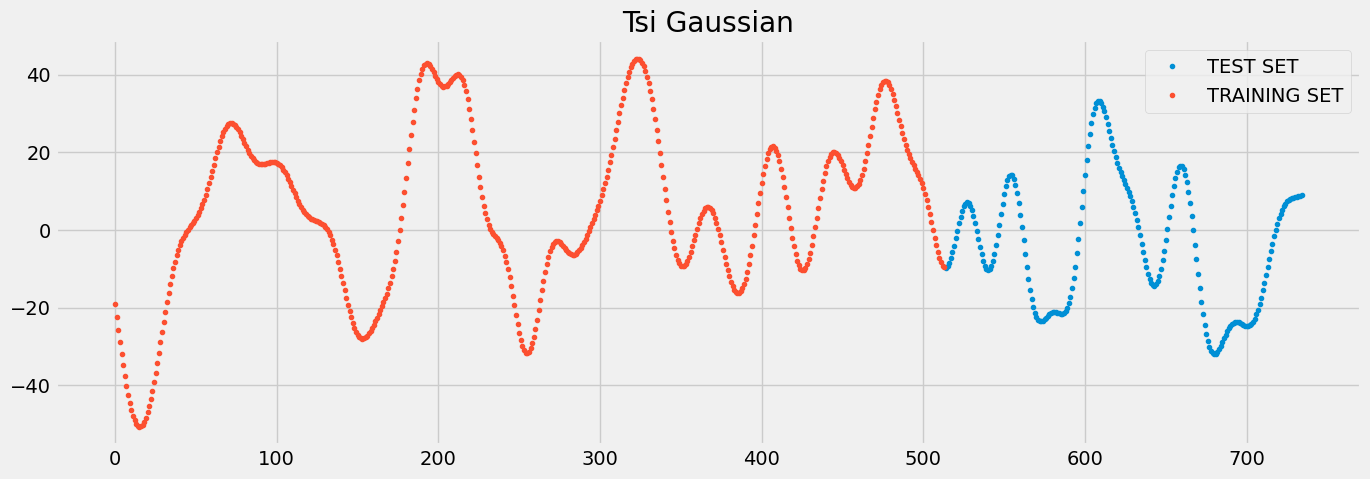

In [16]:
pjme_test \
    .rename(columns={'tsi_gaussian': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'tsi_gaussian': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Tsi Gaussian', style='.')

In [227]:
ticker ="PETR3.SA"

df = yf.download(ticker)

base = df["2018":]



fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name="Ação",
        x=base.index,
        y=base["Close"],
        line=dict(color='blue', width=1))
)
fig.add_trace(
    go.Scatter(
        name="Ação",
        x=base_continua.index,
        y=base_continua["Close"],
        line=dict(color='orange', width=1))
)

[*********************100%***********************]  1 of 1 completed


In [4]:
ticker ="ABEV3.SA"

df = yf.download(ticker)

base = df["2018":]


#Atributos
anteriores = 180
knots = 80
sigma = 0.0003
n_estimators = 300
filepath = "Modelo_XGBoost_teste1.json"



xgboost_model = Criar_modelo_XGBoost(
    base,
    anteriores,
    filepath,
    knots_=knots,
    sigma_=sigma,
    n_estimators_=n_estimators)


[*********************100%***********************]  1 of 1 completed


<AxesSubplot: >

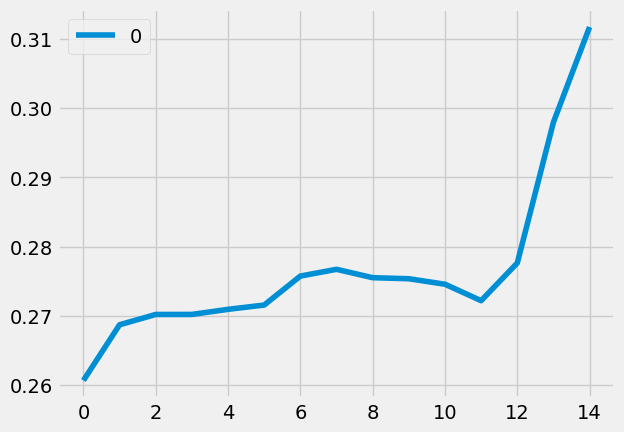

In [327]:
ticker ="ABEV3.SA"

df = yf.download(ticker)

base = df["2018":]


base = base[:"2022-12-12"]

anteriores = 80

qtd_previsoes = 15

knots= 60

sigma = 0.0003

modelo_XGBoost = Carregar_modelo_XGBoost("Modelo_XGBoost_teste1.json")


lista_previsoes =Realizar_previsoes_XGBoost(qtd_previsoes,base,anteriores,modelo_XGBoost,knots,sigma):
    
pd.DataFrame(lista_previsoes).plot()